# 0 Spark Session

Before working with Spark, we need an entry point. The so called *Spark Session* allows us to create DataFrames etc.

In [1]:
spark

# 1 Creating a DataFrame

First, let's create some DataFrame from Python objects. While this is probably not the most common thing to do, it is easy and helpful in some situations where you already have some Python objects.

In [1]:
df = spark.createDataFrame([('Alice', 13), ('Bob', 12)], ['name', 'age'])
print(df.collect())

[Row(name='Alice', age=13), Row(name='Bob', age=12)]


It is also possible to create a PySpark DataFrame from an existing PySpark RDD.

In [2]:
rdd = sc.parallelize([('Alice', 13), ('Bob', 12)])
df = spark.createDataFrame(rdd, ['name', 'age'])
print(df.collect())

[Row(name='Alice', age=13), Row(name='Bob', age=12)]


PySpark also contains a small method for displaying the contents of a DataFrame.

In [3]:
df.show()

+-----+---+
| name|age|
+-----+---+
|Alice| 13|
|  Bob| 12|
+-----+---+



## 1.1 Inspect Schema

The `spark` object has different methods for creating a so called Spark DataFrame object. This object is similar to a table, it contains rows of records, which all conform to a common schema with named columns and specific types. On the surface it heavily borrows concepts from Pandas DataFrames or R DataFrames, although the syntax and many operations are syntactically very different.

As the first step, we want to see the contents of the DataFrame. This can be easily done by using the show method.

In [4]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)



## 1.2 Explicitly specify Schema

It is also possible to explicitly specify the schema, not only by names, but also by types. This is quite useful in the next steps when we want to load data from CSV files.

In [5]:
from pyspark.sql.types import *

data = [('Alice', 13), ('Bob', 12)]
schema = StructType([
    StructField('name', StringType(), True),
    StructField('age', IntegerType(), True),
    ])
    
rdd = sc.parallelize(data)
df = spark.createDataFrame(rdd, schema)
df.show()

+-----+---+
| name|age|
+-----+---+
|Alice| 13|
|  Bob| 12|
+-----+---+



In [6]:
from pyspark.sql import Row

Person = Row('name','age')
alice = Person('Alice',23)
bob = Person('Bob',21)
df = spark.createDataFrame([alice,bob])
df.show()

+-----+---+
| name|age|
+-----+---+
|Alice| 23|
|  Bob| 21|
+-----+---+



# 2 Reading Data

Of course manually creating DataFrames from a couple of records is not the real use case. Instead we want to read data frames files.. Spark supports various file formats, we will use JSON in the following example.

The entrypoint for creating Spark objects is an object called spark which is provided in the notebook and read to use. We will read a file containing some informations on a couple of persons, which will serve as the basis for the next examples

## 2.1 Read JSON data

In [7]:
persons = spark.read.json("s3://dimajix-training/data/persons.json")
persons.show()

+---+------+-------+------+
|age|height|   name|   sex|
+---+------+-------+------+
| 14|   156|  Alice|female|
| 21|   181|    Bob|  male|
| 27|   176|Charlie|  male|
| 24|   167|    Eve|female|
| 19|   172|Frances|female|
| 31|   191| George|  male|
+---+------+-------+------+



In [8]:
persons.printSchema()

root
 |-- age: long (nullable = true)
 |-- height: long (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)



## 2.2 Reading CSV Data

In [10]:
persons = spark.read \
    .option("inferSchema", True) \
    .option("header", True) \
    .csv("s3://dimajix-training/data/persons_header.csv")
persons.show()

+---+------+-------+------+
|age|height|   name|   sex|
+---+------+-------+------+
| 23|   156|  Alice|female|
| 21|   181|    Bob|  male|
| 27|   176|Charlie|  male|
| 24|   167|    Eve|female|
| 19|   172|Frances|female|
| 31|   191| George|female|
+---+------+-------+------+



In [11]:
persons.printSchema()

root
 |-- age: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)



## 2.3 Explicit Schema

We already saw that we can explicitly specify a schema when we create a DataFrame from a Python list of objects. We can also specify a schema when we read data from a storage. This is highly recommended, otherwise Spark would use automatic schema inference, which might hide problems of a changed data delivery.

In [2]:
from pyspark.sql.types import *

schema = StructType([
    StructField("age", LongType(), False),
    StructField("height", LongType(), False),
    StructField("name", StringType(), False),
    StructField("sex", StringType(), False),
])

persons = spark.read \
    .option("header", True) \
    .schema(schema) \
    .csv("s3://dimajix-training/data/persons_header.csv")
    
persons.toPandas()

,age,height,name,sex
0,23,156,Alice,female
1,21,181,Bob,male
2,27,176,Charlie,male
3,24,167,Eve,female
4,19,172,Frances,female
5,31,191,George,female


In [3]:
persons.printSchema()

root
 |-- age: long (nullable = true)
 |-- height: long (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)



# 3 Interacting with Pandas

Now that we can create and read Spark DataFrames, we also want to convert them into Pandas DataFrames. Pandas is a Python package which also offers a concept called *DataFrame*, but that has nothing to do with Spark. Actually Pandas is much older than Spark, and Spark borrowed many ideas and concepts from Pandas (and from R of course).

Nevertheless it is quite useful to convert a Spark DataFrame into a Pandas DataFrame, specifically because the Jupyter Notebook directly supports Pandas DataFrames and renders them much nicer.

In [12]:
pdf = persons.toPandas()
pdf

,age,height,name,sex
0,23,156,Alice,female
1,21,181,Bob,male
2,27,176,Charlie,male
3,24,167,Eve,female
4,19,172,Frances,female
5,31,191,George,female


Pandas also supports graphics, so we can create a (in thius case meaningless) graph of a Pandas DataFrame.

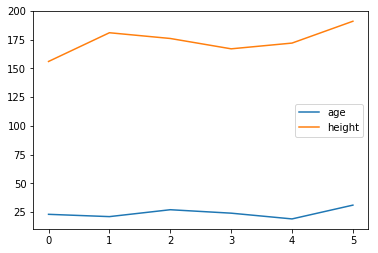

In [13]:
%matplotlib inline
pdf.plot()

## Attention: Beware of huge DatFrames!

Do not forget hat Apache Spark has been designed and built to handle really huge data sets, which do not need to fit into memory. Spark DataFrames con contain billions of rows and are stored in a distributed way on many nodes in a cluster. Actually the contents do not even need to be physically present at all, as long as the input data is accessible.

But calling the toPandas() method will transfer all the records to a single machine (where the Jupyter Notebook runs on) - but maybe this computer does not have enough memory to hold all the data. In this case, you risk that the notebook process will crash with an Out-Of-Memory error (OOM). So you should only use toPandas() when you are really sure that the DataFrame contains a limited amount of records.


# 4 Simple Transformations

## 4.1 Projections

The simplest thing to do is to create a new DataFrame with a subset of the available columns

In [14]:
from pyspark.sql.functions import *

result = persons.select('name', col('age'))
result.toPandas()

,name,age
0,Alice,23
1,Bob,21
2,Charlie,27
3,Eve,24
4,Frances,19
5,George,31


## 4.2 Addressing Columns

Spark supports multiple different ways for addressing a columns. We just saw one way, but also the following methods are supported for specifying a column:

* `df.column_name`
* `df['column_name']`
* `col('column_name')`
* `df[idx]`

All these methods return a Column object, which is an abstract representative of the data in the column. As we will see soon, transformations can be applied to Column in order to derive new values.

### Beware of Lowercase and Uppercase

While PySpark itself is case insenstive concering column names, Python itself is case sensitive. Since the first method for addressing columns by treating them as fields of a Python object *is* Python syntax, this is also case sensitive!

In [16]:
result = persons.select(persons.name)
result.toPandas()

,name
0,Alice
1,Bob
2,Charlie
3,Eve
4,Frances
5,George


## 4.3 Transformations 

The `select` method actually accepts any column object. A column object conceptually represents a column in a DataFrame. The column may either refer directly to an existing column of the input DataFrame, or it may represent the result of a calculation or transformation of one or multiple columns of the input DataFrame. For example if we simply want to transform the name into upper case, we can do so by using a function `upper` provided by PySpark.

In [17]:
result = persons.select(persons.name, upper(persons.name))
result.toPandas()

,name,upper(name)
0,Alice,ALICE
1,Bob,BOB
2,Charlie,CHARLIE
3,Eve,EVE
4,Frances,FRANCES
5,George,GEORGE


### Defining new Column Names
The resulting DataFrame again has a schema, but the column names to not look very nice. But by using the `alias` method of a `Column` object, you can immediately rename the newly created column like you are already used to in SQL with `SELECT complex_operation(...) AS nice_name FROM ...`. 

Technically specifying a new name for the resulting column is not required (as we already saw above), if the name is not specified, PySpark will generate a name from the expression. But since this generated name tends to be rather long and contains the logic instead of the intention, it is highly recommended to always explicitly specify the name of the resulting column using `as`.

In [18]:
result = persons.select(persons.name, upper(persons.name).alias('upper_name'))
result.toPandas()

,name,upper_name
0,Alice,ALICE
1,Bob,BOB
2,Charlie,CHARLIE
3,Eve,EVE
4,Frances,FRANCES
5,George,GEORGE


You can also perform simple mathematical calculations like addition, multiplication etc.

In [19]:
result = persons.select(persons.name, (persons.age**2).alias('age_sqr'))
result.toPandas()

,name,age_sqr
0,Alice,529.0
1,Bob,441.0
2,Charlie,729.0
3,Eve,576.0
4,Frances,361.0
5,George,961.0


In [20]:
result = persons.select(
        concat(
            persons.name,
            lit('_'),
            persons.age.cast('string')
        ).alias('name_age')
    )
result.toPandas()

,name_age
0,Alice_23
1,Bob_21
2,Charlie_27
3,Eve_24
4,Frances_19
5,George_31


In [21]:
numbers = spark.createDataFrame([(x,) for x in range(0,10)], ['number'])
result = numbers.select(
        numbers.number,
        when(numbers.number % 2 == 0, 'even').otherwise('odd').alias('text')
    )

result.toPandas()

,number,text
0,0,even
1,1,odd
2,2,even
3,3,odd
4,4,even
5,5,odd
6,6,even
7,7,odd
8,8,even
9,9,odd


In [22]:
result = persons.select(concat(when(persons.sex == 'male', "Mr ").otherwise("Mrs "), persons.name).alias("salutation"))
result.toPandas()

,salutation
0,Mrs Alice
1,Mr Bob
2,Mr Charlie
3,Mrs Eve
4,Mrs Frances
5,Mrs George


### Common Functions

You can find the full list of available functions at [PySpark SQL Module](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions). Commonly used functions for example are as follows:

* [`concat(*cols)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.concat) - Concatenates multiple input columns together into a single column.
* [`substring(col,start,len)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.substring) - Substring starts at pos and is of length len when str is String type or returns the slice of byte array that starts at pos in byte and is of length len when str is Binary type.
* [`instr(col,substr)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.instr) - Locate the position of the first occurrence of substr column in the given string. Returns null if either of the arguments are null.
* [`locate(col,substr, pos)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.locate) - Locate the position of the first occurrence of substr in a string column, after position pos.
* [`length(col)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.length) - Computes the character length of string data or number of bytes of binary data. 
* [`upper(col)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.upper) - Converts a string column to upper case.
* [`lower(col)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.lower) - Converts a string column to lower case.
* [`coalesce(*cols)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.coalesce) - Returns the first column that is not null.
* [`isnull(col)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.isnull) - An expression that returns true iff the column is null.
* [`isnan(col)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.isnan) - An expression that returns true iff the column is NaN.
* [`hash(cols*)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.hash) - Calculates the hash code of given columns.

Spark also supports conditional expressions, like the SQL `CASE WHEN` construct
* [`when(condition, value)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.when) - Evaluates a list of conditions and returns one of multiple possible result expressions.

There are also some special functions often required
* [`col(str)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.col) - Returns a Column based on the given column name.
* [`lit(val)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.lit) - Creates a Column of literal value.
* [`expr(str)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.expr) - Parses the expression string into the column that it represents

### User Defined Functions
Unfortunately you cannot directly use normal Python functions for transforming DataFrame columns. Although PySpark already provides many useful functions, this might not always sufficient. But fortunately you can *convert* a standard Python function into a PySpark function, thereby defining a so called *user defined function* (UDF). Details will be explained in detail in the training.

## 4.4 Injecting Literal Values

Sometimes it is required to inkect literal values (i.e. strings or numbers) into a transformation expression. Since using simply a string could mean wither a column with that name or the literal itself, Spark offers the function `lit` to explicitly mark a string (or any other value) as a literal. `lit` creates a PySpark column object from the value. This means that all column methods are avilable for the literal.

In [23]:
result = persons.select(concat(lit('Name:'), persons.name, lit(' Age:'), persons.age).alias('text'))
result.toPandas()

,text
0,Name:Alice Age:23
1,Name:Bob Age:21
2,Name:Charlie Age:27
3,Name:Eve Age:24
4,Name:Frances Age:19
5,Name:George Age:31


## 4.5 Exercises

Write a small `select` statement, which puts either "Mr" or "Mrs" into a new column called "salutation" depending on the sex of the person 

In [24]:
## YOU CODE HERE

## 4.6 SQL Expressions

In [ ]:
result = persons.select(
    expr("CASE WHEN sex = 'male' THEN 'Mr' ELSE 'Mrs' END AS salutation")
)

result.toPandas()

## 4.7 Adding Columns

A special variant of a `select` statement is the `withColumn` method. While the `select` statement requires all resulting columns to be defined in as arguments, the `withColumn` method keeps all existing columns and adds a new one. This operation is quite useful since in many cases new columns are derived from the existing ones, while the old ones still should be contained in the result.

Let us have a look at a simple example, which only adds the salutation as a new column:

In [25]:
result = persons.withColumn("salutation", when(persons.sex == "male", 'Mr').otherwise('Mrs'))
result.toPandas()

,number,text
0,0,even
1,1,odd
2,2,even
3,3,odd
4,4,even
5,5,odd
6,6,even
7,7,odd
8,8,even
9,9,odd


As you can see from the example above, `withColumn` always takes two arguments: The first one is the name of the new column (and it has to be a string), and the second argument is the expression containing the logic for calculating the actual contents.

In [ ]:
result = persons.select(
    persons['*'],
    when(persons.sex == "male", 'Mr').otherwise('Mrs').alias("salutation")
)
result.toPandas()

## 4.8 Dropping a Column

PySpark also supports the opposite operation which simply removes some columns from a dataframe. This is useful if you need to remove some sensitive data before saving it to disk:

In [26]:
result2 = result.drop("name","age")
result2.toPandas()

,text
0,even
1,odd
2,even
3,odd
4,even
5,odd
6,even
7,odd
8,even
9,odd


## 4.9 Exercise

Using the `persons` DataFrame, perform the following operations:
* Add a new column `status` which should be `child` if the person is younger than 18 and `adult` otherwise
* Replace the column `name` by a new column `hashed_name` containing the hash value of the name
* Drop the column `sex`

In [27]:
# YOUR CODE HERE

# 5 Filtering

*Filtering* denotes the process of keeping only rows which meet a certain filter criteria. PySpark support two different approaches. The first approach specifies the filtering expression as a PySpark expression using columns:

In [28]:
result = persons.filter(persons.age > 22)
result.toPandas()

,age,height,name,sex
0,23,156,Alice,female
1,27,176,Charlie,male
2,24,167,Eve,female
3,31,191,George,female


The second approach simply uses a string containing an SQL expression:

In [29]:
result = persons.filter("age > 22")
result.toPandas()

,age,height,name,sex
0,23,156,Alice,female
1,27,176,Charlie,male
2,24,167,Eve,female
3,31,191,George,female


When using SQL expressions, you can also work with aliases to address specific DataFrames in case of ambiguous column names:

In [ ]:
result = persons.alias("persons").filter("persons.age > 22 AND height < 170")
result.toPandas()

## 5.1 Exercise

Perform different filter operations:
* Select all women with a height of at least 160
* Select all persons which are younger than 20 or older than 30

In [30]:
# YOUR CODE HERE

## 5.2 Limit Operations

When working with large datasets, it may be helpful to limit the amount of records (like an SQL `LIMIT` operation).

In [ ]:
result = persons.limit(3)
result.toPandas()

# 6 Aggregations

In [ ]:
df = spark.createDataFrame([(x,) for x in range(0,100)], ['value'])
df.limit(10).toPandas()

The simplest aggregation is the number of records in a DataFrame

In [ ]:
df.count()

Spark supports the usual aggregations as we know from SQL:

In [31]:
result = df.select(sum(df.value).alias('sum'), avg(df.value).alias('avg'), min(df.value).alias('min'), max(df.value).alias('max'), count(df.value).alias('count'))
result.toPandas()

,sum,avg,min,max,count
0,4950,49.5,0,99,100


# 7 Making Data Distinct

In [1]:
df = spark.createDataFrame([('Bob',),('Alice',),('Bob',)], ['name'])
df.toPandas()

,name
0,Bob
1,Alice
2,Bob


In [2]:
result = df.distinct()
result.toPandas()

,name
0,Bob
1,Alice


# 8 Grouping & Aggregating

An important class of operation is grouping and aggregation, which is equivalnt to an SQL `SELECT aggregation GROUP BY grouping` statement. In PySpark, grouping and aggregation is always performed by first creating groups using `groupBy` immediately followed by aggregation expressions inside an `agg` method. (Actually there are also some predefined aggregations which can be used instead of `agg`, but they do not offer the flexiviliby which is required most of the time).

Note that in the `agg` method you only need to specify the aggregation expression, the grouping columns are added automatically by PySpark to the resulting DataFrame.

In [33]:
result = persons.groupBy(persons.sex).agg(
    avg(persons.age).alias('avg_age'),
    min(persons.height).alias('min_height'),
    max(persons.height).alias('max_height'))
result.toPandas()

,sex,avg_age,min_height,max_height
0,female,24.25,156,191
1,male,24.00,176,181


Sometimes it may be useful to access all elements of a group as a list. But since `groupBy` does not return a normal DataFrame and requires an aggregate function as the next step, this requires a small trick. Using the `collect_list` function, you can put all elemenets of a single column of every group into a new column.

In [35]:
result = persons.groupBy(persons.sex).agg(
        collect_list(struct(persons.name, persons.age)).alias("list")
)
result.toPandas()

,sex,list
0,female,"[(Alice, 23), (Eve, 24), (Frances, 19), (Georg..."
1,male,"[(Bob, 21), (Charlie, 27)]"


In [ ]:
result.printSchema()

## Aggregation Functions

PySpark supports many aggregation functions, they can be found in the documentation at [PySpark Function Documentation](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions). Aggregation functions are marked as such in the documentation, unfortunately there is no simple overview. Among common aggregation functions, there are for example:

* count
* sum
* avg
* corr
* first
* last

## 8.1 Exercise

Using the `persons` DataFrame, calculate the average height and the number of records per sex.

In [36]:
# YOUR CODE HERE

# 9 Sorting Data

PySpark also supports sorting data with the `orderBy` method. For example we can sort all persons by their name as follows:

In [37]:
result = persons.orderBy(persons.height)
result.toPandas()

,age,height,name,sex
0,23,156,Alice,female
1,24,167,Eve,female
2,19,172,Frances,female
3,27,176,Charlie,male
4,21,181,Bob,male
5,31,191,George,female


If nothing else is specified, PySpark will sort the records in increasing order of the sort columns. If you require descending order, this can be specified by manipulating the sort column with the `desc()` method as follows:

In [38]:
result = persons.orderBy(persons.age.desc())
result.toPandas()

,age,height,name,sex
0,31,191,George,female
1,27,176,Charlie,male
2,24,167,Eve,female
3,23,156,Alice,female
4,21,181,Bob,male
5,19,172,Frances,female


## 9.1 Exercise

As an exercise we want to sort all persons first by their sex and then by their descening age. Sorting by multiple columns can easily be achieved by specifying multiple columns as arguments in the `orderBy` method.

In [39]:
# YOUR CODE HERE

# 10 Joining Data

Every relation algebra also contains join operations which lets you combine multiple tables by a matching criterion. PySpark also supports joins of multiple DataFrames. In order to shed some light on that, we need a second DataFrame in addition to the `persons` DataFrame. Therefore we load some address data as follows:

In [4]:
addresses = spark.read.json("s3://dimajix-training/data/addresses.json")
addresses.toPandas()

,city,name
0,Hamburg,Alice
1,Frankfurt,Bob
2,Berlin,Henry


Now that we have the addresses DataFrame, we want to combine it with the persons DataFrame such that the city of every person is added as a new column. This is achieved by the join method which essentially takes two parameters: The first parameter specifies the second DataFrame to join with, and the second parameter specifies the join condition. In this case we want to join all records, where the name column matches.

In [41]:
result = persons.join(addresses,persons.name == addresses.name)
result.toPandas()

,age,height,name,sex,city,name
0,23,156,Alice,female,Hamburg,Alice
1,21,181,Bob,male,Frankfurt,Bob


Let me make some relevant remarks:

* The resulting DataFrame now contains two `name` columns - one comes from the `persons` DataFrame, the other from the `addresses` DataFrame. Since the join condition could have used some more complex expression, this behaviour is only logical since PySpark cannot assume that all joins simply use directly some column value. For example we could also have transformed the column on the fly by converting the name to upper case directly inside the join condition.
* The result contains only persons where an address was found, although the original `persons` DataFrame contained more persons.
* There are no records of addresses without any person, although the `addresses` DataFrame contains information about some persons not available in the `persons` DataFrame.

So let us first address the first observation. We can easily get rid of the copied `name` column by either performing an explicit select of the desired columns, or by dropping the duplicate columns. Since PySpark records the lineage of every column, the duplicate `name` columns can be addressed by their original DataFrame even after the join operation:

In [42]:
result = persons.join(addresses,persons.name == addresses.name).drop(addresses.name)
result.toPandas()

,name,age,city
0,Alice,23,Hamburg
1,Bob,21,Frankfurt


## 10.1 Join Types

Now let us explain the last two observations. These are due to the used join type, which was a so called *inner* join. In this case, only records with information from both DataFrames are included in the result.

In addition to the *inner* join, PySpark also supports some additional joins:
* *outer join* will contain records for all elements from both DataFrames. If either the left or right DataFrames doesn't contain any information, the result will contain `None` values (= `NULL` values) for the corresponding columns.
* In a *right join*, the second DataFrame (the right DataFrame) as specified as an argument is the leading element. The result will contain records for every record in that DataFrame.
* In a *left join*, the first DataFrame (the left DataFrame) as specified as the object iteself is the leading element. The result will contain records for every record in that DataFrame.

In [43]:
result = persons.join(addresses,persons.name == addresses.name, how="outer")
result.toPandas()

,name,age,city
0,Charlie,27.0,None
1,Bob,21.0,Frankfurt
2,Alice,23.0,Hamburg
3,Eve,24.0,None
4,George,31.0,None
5,Frances,19.0,None
6,None,NaN,Berlin


In [44]:
result = persons.join(addresses,persons.name == addresses.name, how="right").drop(addresses.name)
result.toPandas()

,name,age,city
0,Alice,23.0,Hamburg
1,Bob,21.0,Frankfurt
2,None,NaN,Berlin


In [45]:
result = persons.join(addresses,persons.name == addresses.name, how="left").drop(addresses.name)
result.toPandas()

,name,age,city
0,Alice,23,Hamburg
1,Bob,21,Frankfurt
2,Charlie,27,None
3,Eve,24,None
4,Frances,19,None
5,George,31,None


## 10.2 Join on Column

As a convenience, Spark also supports directly joining on a column that is present in both DataFrames.

In [5]:
result = persons.join(addresses, ["name"], how="outer")
result.toPandas()

,name,age,height,sex,city
0,Charlie,27.0,176.0,male,None
1,Bob,21.0,181.0,male,Frankfurt
2,Alice,23.0,156.0,female,Hamburg
3,Eve,24.0,167.0,female,None
4,George,31.0,191.0,female,None
5,Frances,19.0,172.0,female,None
6,Henry,NaN,NaN,None,Berlin


## 10.3 Exercise

As an exercise, we use another DataFrame loaded from a file called `lastnames.json`, which can be joined to the persons DataFrame again:

In [48]:
lastnames = spark.read.json("s3://dimajix-training/data/lastnames.json")
lastnames.toPandas()

,last_name,name
0,Liddell,Alice
1,Baumeister,Bob
2,Gates,Bob


Now join the lastnames DataFrame to the `persons` DataFrame whenever the `name` column of both DataFrames matches. Note what happens due to the fact that we have two last names for "Bob".

In [49]:
# Your Code Here

# 11 Set Operations

Spark also offers some set operations, like `UNION`, `INTERSECT` and `SUBTRACT`.

First let us create two simple data frames for experiments.

In [6]:
df1 = spark.createDataFrame([
    ['Alice', 23],
    ['Bob', 44],
    ['Charlie', 31]
], ["name", "age"])

df2 = spark.createDataFrame([
    ['Alice', 23],
    ['Bob', 44],
    ['Henry', 31]
], ["name", "age"])

## 11.1 Unions

The most well known operation is a `union` which actually corresponds to an SQL `UNION ALL`, i.e. it will keep duplicate records.

In [7]:
result = df1.union(df2)
result.toPandas()

,name,age
0,Alice,23
1,Bob,44
2,Charlie,31
3,Alice,23
4,Bob,44
5,Henry,31


When you do not want to keep duplicate records, you can simply run a `distinct()` transformation after the `union()`.

In [8]:
result = df1.union(df2).distinct()
result.toPandas()

,name,age
0,Alice,23
1,Henry,31
2,Charlie,31
3,Bob,44


### Union and UnionByName

A simple `union` operation simply takes the schema of the first DataFrame and appends the records of the second data frame. The columns will be matched by their position and types will be changed if required.

In [9]:
df3 = spark.createDataFrame([
    [23, 'Alice'],
    [44, 'Bob'],
    [31, 'Henry']
], ["age", "name"])

In [10]:
result = df1.union(df3)
result.toPandas()

,name,age
0,Alice,23
1,Bob,44
2,Charlie,31
3,23,Alice
4,44,Bob
5,31,Henry


In [11]:
result.printSchema()

root
 |-- name: string (nullable = true)
 |-- age: string (nullable = true)



In [12]:
result = df1.unionByName(df3)
result.toPandas()

,name,age
0,Alice,23
1,Bob,44
2,Charlie,31
3,Alice,23
4,Bob,44
5,Henry,31


## 11.2 Intersect and Subtract

Spark also supports additional set operations like `INTERSECT` and `SUBTRACT`

In [13]:
result = df1.intersect(df2)
result.toPandas()

,name,age
0,Alice,23
1,Bob,44


In [14]:
result = df1.subtract(df2)
result.toPandas()

,name,age
0,Charlie,31


# 12 Caching Data

In some situations, you may want to persist intermediate results. For example iterative algorithms may benefit from *caching* intermediate results, if the same DataFrame is transformed again and again. Spark provides some capabilities to persist intermediate results using the methods `cache()` or `persist(storageLevel)`.

Note that also caching is lazy, which means that records will not be created at the time when you call `cache()` or `persist()` but at the first time when the DataFrame is evaluated. This could be even a simple `count()` action.

In [ ]:
persons.cache()

In [ ]:
persons.storageLevel

In [ ]:
persons.unpersist()

In [ ]:
persons.storageLevel

In [ ]:
persons.persist()

# 13 Using SQL

PySpark also directly supports SQL. In order to work with SQL, you only need to register a PySpark DataFrame as a *temporary view*, which provides a name to a DataFrame which can be referenced in SQL queries later.

In [ ]:
persons = spark.read.json("s3://dimajix-training/data/persons.json")
addresses = spark.read.json("s3://dimajix-training/data/addresses.json")

In [50]:
persons.createOrReplaceTempView("persons")

result = spark.sql("SELECT * FROM persons")
result.toPandas()

,age,height,name,sex
0,23,156,Alice,female
1,21,181,Bob,male
2,27,176,Charlie,male
3,24,167,Eve,female
4,19,172,Frances,female
5,31,191,George,female


## 13.1 Exercise

Perform the following tasks, in order to join `persons` with `addresses`in SQL:

* Register `addresses` DataFrame as `addresses`
* Join `persons` with `addresses`
* Only select persons which are 20 years or older

In [51]:
# YOUR CODE HERE

# 14 User Defined Functions

From time to time you hit a wall where you need a simple transformation, but Spark does not offer an appropriate function in the `pyspark.sql.functions` module. Fortunately you can simply define new functions, so called *user defined functions* or short *UDFs*.

In [15]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

df = spark.createDataFrame([('Alice & Bob',12),('Thelma & Louise',17)],['name','age'])
df.toPandas()

,name,age
0,Alice & Bob,12
1,Thelma & Louise,17


In [16]:
import html

html.escape("Thelma & Louise")

'Thelma &amp; Louise'

## 14.1 Classic Python UDF

First we will create a classical Python UDF (as opposed to a Pandas UDF).

In [17]:
html_encode = udf(html.escape, StringType())

result = df.select(html_encode('name').alias('html_name'))
result.toPandas()

,html_name
0,Alice &amp; Bob
1,Thelma &amp; Louise


As an alternative, you can also use a Python decorator for declaring a UDF:

In [18]:
@udf(StringType())
def html_encode(s):
    return html.escape(s)

result = df.select(html_encode('name').alias('html_name'))
result.toPandas()

,html_name
0,Alice &amp; Bob
1,Thelma &amp; Louise


In [19]:
@udf(StructType([
    StructField("org_name", StringType()), 
    StructField("html_name", StringType())
]))
def html_encode(s):
    return (s,html.escape(s))

result = df.select(html_encode('name').alias('both_names'))
result.toPandas()

,both_names
0,"(Alice & Bob, Alice &amp; Bob)"
1,"(Thelma & Louise, Thelma &amp; Louise)"


If you wanto to use the Python UDF inside a SQL query, you also need to register it, so PySpark knows its name.

In [20]:
html_encode = spark.udf.register("html_encode", lambda s: html.escape(s), StringType())

df.createOrReplaceTempView("famous_pairs")
result = spark.sql("SELECT html_encode(name) FROM famous_pairs")
result.toPandas()

,html_encode(name)
0,Alice &amp; Bob
1,Thelma &amp; Louise


## 14.2 Pandas UDFs

"Normal" Python UDFs are pretty expensive (in terms of execution time), since for every record the following steps need to be performed:
* record is serialized inside JVM
* record is sent to an external Python process
* record is deserialized inside Python
* record is Processed in Python
* result is serialized in Python
* result is sent back to JVM
* result is deserialized and stored inside result DataFrame

This does not only sound like a lot of work, it actually is. Therefore Python UDFs are a magnitude slower than native UDFs written in Scala or Java, which run directly inside the JVM.

But since Spark 2.3 an alternative approach is available for defining Python UDFs with so called *Pandas UDFs*. Pandas is a commonly used Python framework which also offers DataFrames (but Pandas DataFrames, not Spark DataFrames). Spark 2.3 now can convert inside the JVM a Spark DataFrame into a shareable memory buffer by using a library called *Arrow*. Python then can also treat this memory buffer as a Pandas DataFrame and can directly work on this shared memory.

This approach has two major advantages:
* No need for serialization and deserialization, since data is shared directly in memory between the JVM and Python
* Pandas has lots of very efficient implementations in C for many functions

Due to these two facts, Pandas UDFs are much faster and should be preferred over traditional Python UDFs whenever possible.

In [23]:
from pyspark.sql.functions import udf

# Use udf to define a row-at-a-time udf
@udf('double')
# Input/output are both a single double value
def cm_to_inch(v):
      return v*0.393701

result = persons.withColumn('height_inch', cm_to_inch(persons.height))
result.toPandas()

,age,height,name,sex,height_inch
0,23,156,Alice,female,61.417356
1,21,181,Bob,male,71.259881
2,27,176,Charlie,male,69.291376
3,24,167,Eve,female,65.748067
4,19,172,Frances,female,67.716572
5,31,191,George,female,75.196891


Increment a value using a Pandas UDF. The Pandas UDF receives a `pandas.Series` object and also has to return a `pandas.Series` object.

In [24]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

# Use pandas_udf to define a Pandas UDF
@pandas_udf('double', PandasUDFType.SCALAR)
# Input/output are both a pandas.Series of doubles
def pandas_cm_to_inch(v):
    return v*0.393701

result = persons.withColumn('height_inch', pandas_cm_to_inch(persons.height))
result.toPandas()

,age,height,name,sex,height_inch
0,23,156,Alice,female,61.417356
1,21,181,Bob,male,71.259881
2,27,176,Charlie,male,69.291376
3,24,167,Eve,female,65.748067
4,19,172,Frances,female,67.716572
5,31,191,George,female,75.196891


## 14.3 Grouped Pandas Aggregate UDFs

Since version 2.4.0, Spark also supports Pandas aggregation functions. This is the only way to implement custom aggregation functions in Python. Note that this type of UDF does not support partial aggregation and all data for a group or window will be loaded into memory.

In [30]:
@pandas_udf("double", PandasUDFType.GROUPED_AGG)
def mean_udf(v):
    return v.mean()

result = persons.groupBy("sex").agg(mean_udf(persons.age))
result.toPandas()

,sex,mean_udf(age)
0,female,24.25
1,male,24.00


## 14.4 Grouped Pandas Map UDFs
While the example above transforms all records independently, but only one column at a time, Spark also offers a so called *grouped Pandas UDF* which operates on complete groups of records (as created by a `groupBy` method).

For example let's subtract the mean of a group from all entries of a group. In Spark this could be achieved directly by using windowed aggregations, but let's use Pandas instead:

In [29]:
schema = StructType(
    persons.schema.fields + [StructField("avg_height_diff", FloatType())]
)    

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
# Input/output are both a pandas.DataFrame
def with_mean_height_diff(pdf):
    return pdf.assign(avg_height_diff=pdf.height - pdf.height.mean())

result = persons.groupby('sex').apply(with_mean_height_diff)
result.toPandas()

,age,height,name,sex,avg_height_diff
0,23,156,Alice,female,-15.5
1,24,167,Eve,female,-4.5
2,19,172,Frances,female,0.5
3,31,191,George,female,19.5
4,21,181,Bob,male,2.5
5,27,176,Charlie,male,-2.5


# 15 Writing Data

In [61]:
persons.write.mode('overwrite').csv('names_ages')

# 16 WordCount Revisited

Although the famous "word count" exampole doesn't fit really well to the DataFrame world, it is still viable.

In [62]:
text = spark.read.text('s3://dimajix-training/data/alice/')
words = text.select(explode(split(text.value,' ')).alias('word')).filter(col('word') != '')
counts = words.groupBy(words.word).count().orderBy('count',ascending=False)

counts.toPandas()

,word,count
0,the,1664
1,and,780
2,to,773
3,a,662
4,of,596
5,she,484
6,said,416
7,in,401
8,it,356
9,was,329


# 17 Accessing Hive Tables

PySpark supports accessing data in Hive tables. This enables to use Hive as a central database which takes the burden of specyfing the schema for a file over and over again.

First let's retreieve the catalog containing all tables of a specific Hive database:

In [ ]:
tables = spark.catalog.listTables(dbName='training')
tables.toPandas()

Now let's read in one table:

In [ ]:
df = spark.read.table('training.stations')
df.limit(10).toPandas()